In [1]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import maxflow
import argparse
from matplotlib.pyplot import figure
from numpy import asarray
from numpy import save
import imutils

%matplotlib inline

## Input directories

In [2]:
image_dir = r"C:\Users\lucki\WORK\UMBC\DAA\DAA_641-Spring_22-Project_1\test"
src = cv2.imread(os.path.join(image_dir, 'src.jpg'))
sink = cv2.imread(os.path.join(image_dir, 'target.jpg'))
mask = cv2.imread(os.path.join(image_dir, 'mask.png'))

In [3]:
def compute_edge_weights(src, sink):
    """
    Computes edge weights based on matching quality cost.
    :param src: image to be blended (foreground)
    :param sink: background image
    """
    edge_weights = np.zeros((src.shape[0], src.shape[1], 2))

    # Create shifted versions of the matrices for vectorized operations.
    src_left_shifted = np.roll(src, -1, axis=1)
    sink_left_shifted = np.roll(sink, -1, axis=1)
    src_up_shifted = np.roll(src, -1, axis=0)
    sink_up_shifted = np.roll(sink, -1, axis=0)

    # Assign edge weights.
    # For numerical stability, avoid divide by 0.
    eps = 1e-10

    # Right neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_left_shifted - sink_left_shifted, 
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_left_shifted, dtype=np.float) +
                         np.square(sink - sink_left_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 0] = weight / (norm_factor + eps)

    # Bottom neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_up_shifted - sink_up_shifted,
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_up_shifted, dtype=np.float) +
                         np.square(sink - sink_up_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 1] = weight / (norm_factor + eps)
    
    return edge_weights

In [4]:
assert (src.shape == sink.shape), f"Source and sink dimensions must be the same: {str(src.shape)} != {str(sink.shape)}"

# Create the graph
graph = maxflow.Graph[float]()
# Add the nodes. node_ids has the identifiers of the nodes in the grid.
node_ids = graph.add_grid_nodes((src.shape[0], src.shape[1]))

edge_weights = compute_edge_weights(src, sink)

C:\Users\lucki\WORK\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\lucki\WORK\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\lucki\WORK\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:24: Deprec

In [5]:
# Add non-terminal edges
patch_height = src.shape[0]
patch_width = src.shape[1]
for row_idx in range(patch_height):
    for col_idx in range(patch_width):
        # right neighbor
        if col_idx + 1 < patch_width:
            weight = edge_weights[row_idx, col_idx, 0]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx][col_idx + 1],
                           weight,
                           weight)

        # bottom neighbor
        if row_idx + 1 < patch_height:
            weight = edge_weights[row_idx, col_idx, 1]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx + 1][col_idx],
                           weight,
                           weight)

        # Add terminal edge capacities for the pixels constrained to
        # belong to the source/sink.
        if np.array_equal(mask[row_idx, col_idx, :], [0, 255, 255]):
            graph.add_tedge(node_ids[row_idx][col_idx], 0, np.inf)
        elif np.array_equal(mask[row_idx, col_idx, :], [255, 128, 0]):
            graph.add_tedge(node_ids[row_idx][col_idx], np.inf, 0)

In [6]:
# sgm = graph.get_grid_segments(node_ids)


In [7]:
# edge_weights[:-1].shape

In [8]:
# sgm.shape == node_ids.shape
# img2 = np.int_(np.logical_not(sgm))

# # Show the result.
# plt.imshow(mask)
# plt.show()

In [9]:
# Compute max flow / min cut.
flow = graph.maxflow()

In [10]:
sgm = graph.get_grid_segments(node_ids)

In [11]:
flow, sgm.shape

(12.058232585748879, (353, 271))

## Get the segments of the nodes in the grid.

In [12]:
canvas = np.zeros(sink.shape, dtype=np.uint8)

In [13]:
sink[sgm] = src[sgm]

image = sink

## PLotting the 2d_graphs

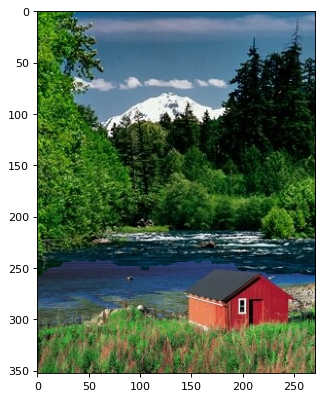

In [14]:
rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
figure(figsize=(10, 6), dpi=80)
plt.imshow(rgb_img);

plt.savefig(os.path.join(image_dir, '2.c.png'))

In [15]:
src.shape[:2]

(353, 271)

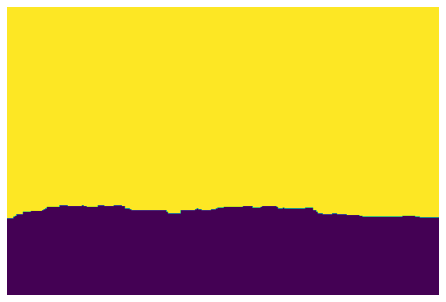

In [16]:
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))

# Show the result.
fig = plt.figure(frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)


# img2 = img2.T
# img2 = cv2.flip(img2, 0)
# img2 = cv2.rotate(img2, cv2.cv2.ROTATE_90_CLOCKWISE)

ax.imshow(img2, aspect='auto')
fig.savefig("{}/temp.png".format(image_dir))

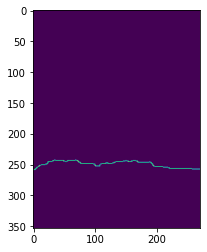

In [17]:
img = cv2.imread("{}/temp.png".format(image_dir))
os.remove("{}/temp.png".format(image_dir))
# resize image
resized_image = cv2.resize(img, src.shape[:2][::-1]) 
# Convert to graycsale
img_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
plt.imshow(edges)
# Display Canny Edge Detection Image
cv2.imwrite('{}/2.b.png'.format(image_dir), edges)
# save to npy file
save('{}/2.b.npy'.format(image_dir), edges)

# Plotting of ndarray

In [18]:
# import cv2
# import numpy as np

# dst = cv2.addWeighted(src, 0.5, sink, 0.7, 0)

# img_arr = np.hstack((src, sink))
# # Show the result.
# plt.imshow(dst)
# plt.show()

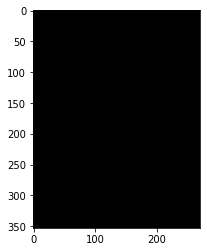

In [19]:
rgb_img = cv2.cvtColor(canvas , cv2.COLOR_BGR2RGB)
# figure(figsize=(8, 6), dpi=80)
plt.imshow(rgb_img)
# plt.savefig('src[sgm] = canvas[sgm].png')
plt.show()

In [20]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# Some legacy ouputs

- 1. sink[sgm] = src[sgm] `# OG`
- 2. src[sgm] = canvas[sgm] `# canvas = np.multiply(mask, [0])` ` # source cutted`
- 3. sink[sgm] = canvas[sgm] `# canvas = np.multiply(mask, [0])` ` # target cutted`